### Environment Setup

#### Option1: Upload files on the run
This entails that the requirement, key, and data need to download again whenever the colab session ends.

In [ ]:
# Creating directories
!mkdir -p data/raw_download data/raw_combine data/train data/test

In [ ]:
from google.colab import files
import os

def upload_file():
    uploaded = files.upload()

    for fn in uploaded.keys():

        # Check if file with same name exists, and remove it if it does
        if os.path.exists(fn):
            os.remove(fn)

        # Write the new file
        with open(fn, 'wb') as file:
            file.write(uploaded[fn])

        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

In [ ]:
# upload package requirements
file_name = "requirements.txt"
if os.path.exists(file_name):
    os.remove(file_name)
upload_file()

In [ ]:
# upload _alpaca_api_key.key
key_file_name = "_alpaca_api_key.key"
if os.path.exists(key_file_name):
    os.remove(key_file_name)
upload_file()

#### Option 2: Mounting to google drive, and upload file to google drive
create MSML602/Final folder in main page of google drive. upload requirements.txt, key, and data folder to that location.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

set the folder as working directory

In [ ]:
%cd /content/drive/MyDrive/MSML602/Final

#### Install packages, setup dir, and environment variables

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade typing

####After finish running the above code, restart session through "Runtime-Restart Session", before running the remaining of the code;
**Note that if option 2 is selected for file management, after session restart, cells in it need to be re-run to re-mount the drive.**

---



#### Library Import

In [1]:
# Read the API key and secret from _alpaca_api_key.key and store them in variables.
def parse_keys(filename):
    keys = {}
    with open(filename, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                keys[key.strip()] = value.strip()
    return keys

keys = parse_keys("alpaca_api/_alpaca_api_key.key")
# =>
# keys = parse_keys("_alpaca_api_key.key")

API_KEY = keys.get('API_KEY')
SECRET_KEY = keys.get('SECRET_KEY')

In [2]:
# api = tradeapi.REST('<APCA-API-KEY-ID>', '<APCA-API-SECRET-KEY>', api_version=
import pandas as pd
pd.set_option('display.max_rows', None)
import pandas_ta as ta
import numpy as np
import scipy as sp
import time
import json
import matplotlib.pyplot as plt
import os
import ast
from datetime import datetime
from enum import Enum
# import copy
# import threading
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# from string import Template

from alpaca.data import Trade, Snapshot, Quote, Bar
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import (
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
    StockLatestTradeRequest,
    StockLatestQuoteRequest,
    StockSnapshotRequest,
    StockLatestBarRequest,
)
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import Exchange, DataFeed
from alpaca.data.models import BarSet, QuoteSet, TradeSet

#### Download Helper Functions

In [3]:
data_source = DataFeed.IEX # DataFeed. is default/free; SIP & OTC are available through paid subscription
data_source_str = str(data_source)[-3:]

stock_client = StockHistoricalDataClient(API_KEY,  SECRET_KEY)

# pre = 'bar_set'
post = 'raw'
default_data_pth = 'data' #currently, launch by default from the project main folder

save_template = "{data_pth}/{data_folder}/{pre}_{time_str}_{symbol_str}_{timeframe_str}_{post}_{data_source_str}.csv"


def get_bars(symbol_lst, timeframe, start, end, limit, adjustment = 'all'):
    request = StockBarsRequest(
        symbol_or_symbols=symbol_lst, timeframe=timeframe, start=start, end=end, limit=limit, adjustment=adjustment, feed = data_source
    )

    print('Start request')
    bar_set = stock_client.get_stock_bars(request_params=request)
    print('End request')

    return bar_set

############################################################################################################
def format_save_pth(symbol, timeframe, start, end,
                    pre      = '', post = post,
                    data_pth = default_data_pth,
                    type     = 'bars',
                    data_folder   = 'raw_download'):

    # symbol_str = symbol
    start_str  = start.strftime('%Y%m%d')
    end_str    = end.strftime('%Y%m%d')
    time_str   = f'{start_str}_{end_str}'

    csv_pth = save_template.format(data_pth = data_pth, data_folder = data_folder, data_type = '{data_type}', pre = pre, symbol_str = symbol, time_str = time_str, timeframe_str = timeframe.value, post = post, data_source_str = data_source_str)
    return csv_pth

'''
Get data for a single symbol from start to end in a single attempt TODO: autometically determine what new data to download; instead of downloading everything, only download the new dataXXXXXXXXXXXXXXXXXXXX Trerrible idea?

    Expected Input:
        Request Parameters:
            symbol (use [symbol] in request)
            timeframe
            start: datetime object
            end  : datetime object
            limit: None by default
        Path Parameters:
            pre               : prefix of the csv file name. Default "". This is before "bar_set" or "trade_set", should have a trailing "_" if not empty
            post              : postfix of the csv file name. Default "raw". This is after the timeframe, should have a leading "_" if not empty
            data_pth          : path to the data folder
        download          : if true download new data, otherwise read from existing csv
        adjustment        : 'all', 'raw', 'split_only', 'dividend_only', 'none' # FIXME: look up alpaca API for exact possible inputs
        type              : 'bars' or 'trades' # TODO: add 'quotes'

    Expected Result:
        1) return:
            a pandas dataframe with ALL SYMBOLS INCLUDED, has multi-level index (symbol, timestamp), and with the following features/columns:
                symbol, timestamp,                    open, high, low,  close,  volume,   trade_count, vwap
                ARBB,   2023-04-05 15: 14: 00+00: 00, 3.6,  3.75, 3.55, 3.6,    297401.0, 213.0,       3.615044
                ARBB,   2023-04-05 15: 15: 00+00: 00, 3.6,  3.85, 3.55, 3.85,   63472.0,  336.0,       3.708484
                ARBB,   2023-04-05 15: 16: 00+00: 00, 3.8,  3.9,  3.75, 3.7925, 44114.0,  231.0,       3.835715
        2) FEATURE REMOVED: a saved .csv file of the returned pandas dataframe, according to the save_template
            This feature is now removed; all file-saving is now done in the get-load of data section.

    Useage:
        df = get_and_process_data(symbol_lst, timeframe, start, end, limit = None, download=False, pre = '', post = post, data_pth = default_data_pth, type = 'bars', adjustment ='all')


    Steps/Process:
        1. Format csv_pth
        2.a. If download is True, get data from Alpaca API, and save to csv_pth
        2.b. If download is False, read from csv_pth
'''
def get_and_process_data(symbol, timeframe, start, end, limit = None, adjustment ='all',
                         pre      = 'bar_set', post = post,
                         data_pth = default_data_pth,
                         type     = 'bars',
                         get_data = get_bars):

    print("Getting Data for symbol:", symbol)
    csv_pth = format_save_pth(symbol, timeframe, start, end,
                            pre      = pre,      post = post,
                            data_pth = data_pth,
                            type     = type)

    print("csv_pth: ", csv_pth)

    if os.path.exists(csv_pth) == False:
        print(f'Downloading {type} for {symbol}:')
        dataset = get_data([symbol], timeframe, start, end, limit, adjustment = adjustment)

        # DEBUG

        df = dataset.df
        if type == 'trades':
            print(df.columns.tolist())
            df.drop(['exchange', 'id', 'conditions', 'tape'], axis = 1, inplace=True)
            print(df.columns.tolist())

        start_time = time.time()
        print(f'start saving to csv at: {csv_pth}')
        df.to_csv(csv_pth, index=True, index_label=['symbol', 'timestamp'])                       # note that the index_label is necessary; if not specified, the index name will not be saved
        print(f'csv saving completed in {time.time()-start_time:.2f} seconds\n')
    else:
        start_time = time.time()
        print(f'reading from csv at: {csv_pth}')
        df = pd.read_csv(csv_pth, index_col = ['symbol', 'timestamp'])                            # note how index_label is used to save, and index_col is used to read... bizarre ain't it?
        print(f'csv reading completed in {time.time()-start_time:.2f} seconds\n')

    return df


'''
helper function for splitting up the entire time period into smaller chunks (so that download doesn't fail)
and protect agaisnt download that does fail half way--don't need to completely restart, as some data is already received and saved

TODO: maybe try multi-threaded request?
'''
def get_next_end(start, raw_end, type = 'bars'):
    if type == 'bars':
        end = start.replace(day=1) + relativedelta(years=+1)
    elif type == 'trades':
        if (start.day < 16):
            end = start.replace(day=16)
        else:
            end = start.replace(day=1) + relativedelta(months=+1)

    if end > raw_end:
        end = raw_end
    return end

'''
Get data for a single symbol from start to end in a single attempt TODO: autometically determine what new data to download; instead of downloading everything, only download the new dataXXXXXXXXXXXXXXXXXXXX Trerrible idea?

    Expected Input:
        dfs: a list of different time_sessions; each time_session is a list of dataframes for each symbol

    Expected Result:
        1) return:
            a pandas dataframe with ALL SYMBOLS INCLUDED, has multi-level index (symbol, timestamp), sorted by timestamp, and with the following features/columns:
                symbol, timestamp,                    open, high, low,  close,  volume,   trade_count, vwap
                ARBB,   2023-04-05 15: 14: 00+00: 00, 3.6,  3.75, 3.55, 3.6,    297401.0, 213.0,       3.615044
                ARBB,   2023-04-05 15: 15: 00+00: 00, 3.6,  3.85, 3.55, 3.85,   63472.0,  336.0,       3.708484
                ARBB,   2023-04-05 15: 16: 00+00: 00, 3.8,  3.9,  3.75, 3.7925, 44114.0,  231.0,       3.835715
        2) FEATURE REMOVED: a saved .csv file of the returned pandas dataframe, according to the save_template
            This feature is now removed; all file-saving is now done in the get-load of data section.

    Useage:
        df = get_and_process_data(symbol_lst, timeframe, start, end, limit = None, download=False, pre = '', post = post, data_pth = default_data_pth, type = 'bars', adjustment ='all')


    Steps/Process:
        1. Format csv_pth
        2.a. If download is True, get data from Alpaca API, and save to csv_pth
        2.b. If download is False, read from csv_pth
'''



'''
# for long timeframe and large symbol num, it might be necessary to split up the request, thus this function is needed TODO: autometically split up the request, and use this as default

    Expected Input:
        Request Parameters: Same as get_and_process_data

    Expected Result:
'''


def get_load_of_data(symbol_lst, timeframe, start, end, limit = None, adjustment = 'all',
                     pre      = '', post = post,
                     data_pth = default_data_pth,
                     type     = 'bars',
                     combine  = False):
    get_data = get_bars
    if type == 'bars':
        get_data = get_bars
        pre = pre + 'bar_set'
    elif type == 'trades':
        get_data = get_trades
        pre = pre + 'trade_set'


    raw_start = start
    raw_end = end

    limit = None
    time_strs = []

    start_time = time.time()
    print('Start getting multiple bars file')

    start = raw_start
    if type == 'bars':
        start = start.replace(day=1, month = 1) # start from the first day of the month
    dfs = []
    if start >= raw_end:
        raise Warning(f'start time {start} is later than end time {raw_end}')
    for symbol in symbol_lst:
        current_start = start  # Assuming initial_start is defined as the starting point
        symbol_dfs = []

        while current_start < raw_end:
            end = get_next_end(current_start, raw_end, type=type)

            start_str = current_start.strftime('%Y%m%d')
            end_str = end.strftime('%Y%m%d')
            time_str = f'{start_str}_{end_str}'
            print('getting data for time session: ', time_str)

            if not time_str in time_strs:
                time_strs.append(time_str)

            df = get_and_process_data(symbol, timeframe, current_start, end, limit, adjustment,
                                    pre=pre, post=post, data_pth=data_pth, type=type, get_data=get_data)

            if combine:
                symbol_dfs.append(df)

            current_start = end

        if combine:
            symbol_df = pd.concat(symbol_dfs)
            dfs.append(symbol_df)
            csv_pth = format_save_pth(symbol, timeframe, start, end,
                                        pre      = pre,      post = post,
                                        data_pth = data_pth,
                                        type     = type,
                                        data_folder = 'raw_combine')

            if os.path.exists(csv_pth) == False:
                print('saving combined df to: ', csv_pth)
                symbol_df.to_csv(csv_pth, index=True, index_label=['symbol', 'timestamp'])



    print(f'All files downloaded and processed in {time.time()-start_time:.2f} seconds')

    print('time_strs: ', time_strs)

    return dfs



##### Testing Raw Data Download

In [4]:
# # symbol_lst = ['PDD', 'DQ', 'ARBB', 'JYD', 'MGIH', 'NVDA', 'AAPL']
symbol_lst = ["MSFT"]
timeframe = TimeFrame.Minute
start = datetime(2020,1,1) # 2020-01-01 is wednesday
end = datetime(2021,1,1)

print('start getting data\n')
dfs = get_load_of_data(symbol_lst, timeframe, start, end, limit = None, adjustment = 'all',
                        pre = '', post = post,
                        type = 'bars',
                        combine = True)

for df in dfs:
    print(df.head())

start getting data

Start getting multiple bars file
getting data for time session:  20200101_20210101
Getting Data for symbol: MSFT
csv_pth:  data/raw_download/bar_set_20200101_20210101_MSFT_1Min_raw_IEX.csv
reading from csv at: data/raw_download/bar_set_20200101_20210101_MSFT_1Min_raw_IEX.csv
csv reading completed in 0.27 seconds

All files downloaded and processed in 0.27 seconds
time_strs:  ['20200101_20210101']
                                    open    high     low   close  volume  \
symbol timestamp                                                           
MSFT   2020-01-01 00:03:00+00:00  152.44  152.44  152.44  152.44   280.0   
       2020-01-01 00:08:00+00:00  152.44  152.44  152.44  152.44   226.0   
       2020-01-01 00:12:00+00:00  152.40  152.40  152.40  152.40  1057.0   
       2020-01-01 00:25:00+00:00  152.44  152.44  152.44  152.44   673.0   
       2020-01-01 00:27:00+00:00  152.40  152.40  152.38  152.38  1276.0   

                                  trade_count  

### Custom Indicator Helper Functions

#### Normalization of close value

Note that normalization takes place here before indication happens. This is done so that the indicated data which are directly related to price don't need additional normalization.

In [5]:
# TODO: Trade count, volume should be normalized with respect to total volume/market volume.

In [6]:
# read previously generated normalization parameters for symbols if it exists
norm_params_pth = "norm_params.csv"
norm_params = pd.DataFrame(columns=['symbol', 'close_mean', 'close_std', 'trade_count_mean', 'trade_count_std', 'volume_mean', 'volume_std']).set_index('symbol')
if os.path.exists(norm_params_pth):
    norm_params = pd.read_csv(norm_params_pth, index_col='symbol')
print(norm_params.head())

# This following normalization function should be applied to training set of each symbol; the returned mean & varaince should be stored, and used to normalize validation set.


# Normalize data, and save the normalization parameters for each symbol in norm_params dataframe
def normalize_raw_price(df_original):
    df = df_original.copy()
    # if normalization parameters for this symbol already exist, use them
    symbol = df.index[0][0]
    if symbol in norm_params.index:
        print("found existing norm_param")
        row = norm_params.loc[symbol]
        close_mean       = row['close_mean']
        close_std        = row['close_std']
        trade_count_mean = row['trade_count_mean']
        trade_count_std  = row['trade_count_std']
        volume_mean      = row['volume_mean']
        volume_std       = row['volume_std']

    else:
        # Calculate mean and std for 'close'
        close_mean = df['close'].mean()
        close_std  = df['close'].std()

        # Normalize 'trade_count' independently
        trade_count_mean  = df['trade_count'].mean()
        trade_count_std   = df['trade_count'].std()

        # Normalize 'volume' independently
        volume_mean = df['volume'].mean()
        volume_std  = df['volume'].std()

        # Save normalization parameters for each symbol in norm_params dataframe
        norm_params.loc[symbol] = [close_mean, close_std, trade_count_mean, trade_count_std, volume_mean, volume_std]
        # Save symbols_norm_params dataframe to csv file
        norm_params.to_csv(norm_params_pth)

    for column in df.columns:
        if column not in ['close', 'trade_count', 'volume']:
            df[column] = (df[column] - close_mean) / close_std

    df['trade_count'] = (df['trade_count'] - trade_count_mean) / trade_count_std
    df['volume'] = (df['volume'] - volume_mean) / volume_std

    return (symbol, df)

Empty DataFrame
Columns: [close_mean, close_std, trade_count_mean, trade_count_std, volume_mean, volume_std]
Index: []


In [7]:
symbol, df = normalize_raw_price(dfs[0])
print(df.head())
print(norm_params)

                                      open      high       low   close  \
symbol timestamp                                                         
MSFT   2020-01-01 00:03:00+00:00 -1.452613 -1.452613 -1.452613  152.44   
       2020-01-01 00:08:00+00:00 -1.452613 -1.452613 -1.452613  152.44   
       2020-01-01 00:12:00+00:00 -1.454337 -1.454337 -1.454337  152.40   
       2020-01-01 00:25:00+00:00 -1.452613 -1.452613 -1.452613  152.44   
       2020-01-01 00:27:00+00:00 -1.454337 -1.454337 -1.455199  152.38   

                                    volume  trade_count      vwap  
symbol timestamp                                                   
MSFT   2020-01-01 00:03:00+00:00 -0.161442    -0.688351 -1.452613  
       2020-01-01 00:08:00+00:00 -0.161584    -0.689711 -1.452613  
       2020-01-01 00:12:00+00:00 -0.159410    -0.685631 -1.454337  
       2020-01-01 00:25:00+00:00 -0.160414    -0.688351 -1.452613  
       2020-01-01 00:27:00+00:00 -0.158837    -0.684272 -1.454768  
     

#### Generate Indicated Data

#### Indicator helper functions

In [8]:
class IndicatorParam(Enum):
    ADX = {'length':14}
    RSI = (1,1)
    BBANDS = 20

def add_time_embedding(df):
    # Create a column from the timestamp index (second index), make sure the index is timezone aware (in UTC);
    df.loc[:, '_timestamps_col'] = pd.to_datetime(df.index.get_level_values(1), utc=True)

    # Convert the index to Eastern timezone
    df.loc[:, '_edt_time'] = df['_timestamps_col'].dt.tz_convert('US/Eastern')

    # Extract the time of day (in hours) as a new column
    df.loc[:, '_edt_hour']      = df['_edt_time'].dt.hour + df['_edt_time'].dt.minute / 60
    df.loc[:, 'edt_dayofweek'] = df['_edt_time'].dt.dayofweek

    # Create a new column with the time of day scaled from 0.0 (9:30 am) to 1.0 (1:00 pm)
    start_hour, end_hour       = 9.5, 16.0
    df.loc[:, 'edt_scaled']    = (df['_edt_hour'] - start_hour) / (end_hour - start_hour)
    df.loc[:, 'is_core_time']  = ((df['edt_scaled'] >= 0) & (df['edt_scaled'] <= 1)).astype(int)

    df.drop(columns=['_timestamps_col', '_edt_time', '_edt_hour'], inplace=True)

def append_indicators(df, mock_trade = True): # note that the mocktrade version removes the final row -- becuase it becomes NaN in rise and fall
    df.ta.ema(append=True, length = 14)
    df.ta.dema(append=True)
    df.ta.tema(append=True)
    df.ta.bbands(append=True)
    df.ta.rsi(append=True)
    df.ta.cci(append=True)
    # df.ta.dmi(append=True) # not working
    # Add ADX
    df.ta.adx(append=True)

    add_time_embedding(df) # very inefficient compared to pandas_ta indicators;
    # # the previous indicators in total used 0.025 seconds on a week's data, this one took 0.065 seconds

    mock_trade_df = None
    df.dropna(inplace = True)
    if mock_trade:
        df['next_high'] = df['high'].shift(-1)
        df['next_fall'] = df['low'].shift(-1)
        df.dropna(inplace = True)
        df_reset      = df.reset_index()
        new_df        = df_reset[['symbol','timestamp', 'next_high', 'next_fall']]
        mock_trade_df = pd.melt(new_df, id_vars=['symbol','timestamp'], value_vars=['next_high', 'next_fall'], var_name='price_type', value_name='price')
        mock_trade_df.set_index('timestamp', inplace=True)
        mock_trade_df.sort_index(inplace=True)
        df.drop(columns=['next_high', 'next_fall'], inplace=True)

    columns_2_drop_lst =    ['open', 'high', 'low', 'volume', 'trade_count', \
                            f"DMN_{IndicatorParam.ADX.value['length']}", f"DMP_{IndicatorParam.ADX.value['length']}"]
    # next_high and next_fall columns can be used to approximate minute level trade action.
    # will delete them after creating new dataframe and saving it.

    # for column in columns_2_drop_lst:
    # if column in df.columns         :
    # df.dropna(inplace = True)?
    df.drop(columns=columns_2_drop_lst, inplace=True)
    feature_list = list(df.columns)

    # print("col_list: ", feature_list)
    return feature_list, mock_trade_df


"""
    This function is used to check if the feature_lst already exists in feature_hist_df;
    if so use the id of the existing record; if not, create a new record
    this is to avoid saving the same feature set multiple times and mixing them up.
"""
def log_feature_record(feature_lst, feature_hist_df):
    start_time2 = time.time()
    feature_set  = set(feature_lst)
    feature_num  = len(feature_lst)
    exist_record = False
    id           = 0

    for index, record in feature_hist_df.iterrows():
        print("type of feature list is:", type(record['feature_lst']))
        record_feature_set = set(ast.literal_eval(record['feature_lst']))
        record_feature_num = int(record['feature_num'])
        record_id          = int(record['id'])

        if record_feature_num == feature_num:
            exist_record = False
            id           = max(id, record_id)

        if record_feature_set == feature_set:
            exist_record = True
            id           = record_id
            print('found existing feature_hist')
            break

    # If no existing record found, insert a new row
    if not exist_record:
        current_timestamp = datetime.now()
        new_row           = {'feature_num': feature_num, 'timestamp': current_timestamp, 'feature_lst': str(feature_lst), 'id': id}
        feature_hist_df   = feature_hist_df._append(new_row, ignore_index=True)

    feature_record = f'{feature_num}feature{id}' # later used to construct save_pth

    return feature_record, feature_hist_df


# TODO: Split up this function by cutting parts of it to be represented as helper functions
def indicate(symbol_lst = ['NVDA','AAPL','MSFT','GOOG','TSLA'], training = True):
    timeframe = TimeFrame.Minute

    # training = False # HYPERPARAMETER
    pre  = "bar_set"
    post = "raw"

    # train = '20200101_20230101'; test = '20230101_20230701'
    # TODO: Comback to resolve this when
    # when testing data is getting generated, for each timestamp where data exist, does information for other symbols need to be inferred? Or should they be predicted seperately?

    if training:
        start = datetime(2020, 1, 1)
        end   = datetime(2023, 1, 1)
    else:
        start = datetime(2023, 1, 1)
        end   = datetime(2023, 7, 1)

    time_str   = start.strftime('%Y%m%d') + '_' + end.strftime('%Y%m%d')
    # Download all required data using alpaca_history's get_loads_of_data
    get_load_of_data(symbol_lst, timeframe, start, end, limit = None, adjustment = 'all',
                    pre      = '', post = post,
                    type     = 'bars',
                    combine  = True)

    # Load feature history record
    features_hist_pth = 'features_hist.csv'
    if os.path.exists(features_hist_pth):
        feature_hist_df = pd.read_csv(features_hist_pth)
    else:
        feature_hist_df = pd.DataFrame(columns=['feature_num', 'timestamp','feature_lst', 'id'])


    # Generate save path and input path

    timeframe       = TimeFrame.Minute.value
    data_source     = DataFeed.IEX # DataFeed. is default/free; SIP & OTC are available through paid subscription
    data_source_str = str(data_source)[-3:]

    input_pth_template = '{data_pth}/raw_combine/{pre}_{time_str}_{symbol}_{timeframe}_{post}_{data_source}.csv'.format(\
                            data_pth = default_data_pth, pre = pre, time_str = time_str, timeframe = timeframe, post = post, data_source = data_source_str, symbol = '{symbol}')
    save_pth_template  = '{data_pth}/{purpose}/{pre}_{time_str}_{symbol}_{timeframe}_{feature_record}_{data_source}.csv'.format(\
                            data_pth = default_data_pth, pre = pre, time_str = time_str, timeframe = timeframe, data_source = data_source_str, purpose = '{purpose}', symbol = '{symbol}', feature_record = '{feature_record}')

    if training == True:
        save_pth_template = save_pth_template.format(purpose = 'train', symbol = '{symbol}', feature_record = '{feature_record}')
        mock_trade        = False
    else:
        save_pth_template = save_pth_template.format(purpose = 'test', symbol = '{symbol}', feature_record = '{feature_record}')
        mock_trade        = False # True

    dfs = []
    for symbol in symbol_lst:
        input_path                  = input_pth_template.format(pre = 'bar_set', symbol = symbol, time_str = time_str, timeframe = timeframe, post = 'raw')
        indicated_save_pth_template = save_pth_template.format(pre = 'bar_set', symbol = symbol, time_str = time_str, timeframe = timeframe, feature_record = '{feature_record}')
        df                          = pd.read_csv(input_path, index_col = ['symbol', 'timestamp'])
        print(df.shape)


        total_calculation_time = 0
        total_csv_saving_time  = 0
        # Create a new dataframe for each group
        start_time = time.time()
        print('start calculating indicators...')

        feature_lst = []

        # groups = df.groupby('symbol')
        # for symbol, df in groups:
        # symbol  : the symbol of the group (in this case, the unique values in 'index_1')
        start_time2 = time.time()

        feature_lst, mock_trade_df = append_indicators(df, mock_trade = mock_trade)

        calculation_time        = time.time() - start_time2
        total_calculation_time += calculation_time
        print(f'finished calculating indicators for {symbol} in {calculation_time} seconds')

        # Check if the feature_lst already exists in feature_hist_df;
        #   if so use the id of the existing record; if not, create a new record
        # this is to avoid saving the same feature set multiple times and mixing them up.
        feature_record, feature_hist_df = log_feature_record(feature_lst, feature_hist_df)

        save_pth        = indicated_save_pth_template.format(feature_record = feature_record)
        mock_trade_path = f'{default_data_pth}/test/mock_trade/{symbol}{time_str}_{symbol}.csv'
        if mock_trade:
            print('start saving to: ', save_pth, '\n', mock_trade_path)
            assert 2*df.shape[0] == mock_trade_df.shape[0]
            mock_trade_df.to_csv(mock_trade_path)
        else:
            print('start saving to: ', save_pth)
        df.to_csv(save_pth, index=True, index_label=['symbol', 'timestamp'])
        csv_saving_time        = time.time() - start_time2
        total_csv_saving_time += csv_saving_time
        print(f'finished calculating indicators for {symbol} in {csv_saving_time:4.2f} seconds')
        dfs.append(df)
        # df.to_csv(f'data/csv/test.csv', index=True, index_label=['symbol', 'timestamp'])

    print(f'finished calculating indicators for all symbol_lst in {time.time() - start_time} seconds')
    print(feature_lst)

    feature_hist_df.to_csv(features_hist_pth, index=False)
    return dfs

#### Training Data

In [9]:
# Here the prediction target is the deviation from the final available stock price.
def get_windowed_XY_data(df, pred_dists):
    N = df.shape[0]
    new_N = N-hist_window-max(pred_dists)

    X_lst = []
    for i in range(hist_window):
        timestep = df.iloc[i:N-hist_window+i-max(pred_dists), :].values
        X_lst.append(timestep)
        # print(timestep.shape)
    X = np.stack(X_lst, axis=1)
    # (N, hist_window, feature_num)

    Y_lst = []
    start_prices = df.iloc[hist_window-1:hist_window-1+new_N,0].values

    for i in pred_dists:
        timestep = df.iloc[hist_window-1+i:hist_window-1+i+new_N,0].values # 0 for 'close' price
        target = timestep-start_prices
        Y_lst.append(target)
        # print(timestep.shape)
    Y = np.stack(Y_lst, axis=1)
    # (N, pred_)

    return X,Y


In [10]:
dfs = indicate(symbol_lst = ["MSFT"], training = True)
df = dfs[0]

Start getting multiple bars file
getting data for time session:  20200101_20210101
Getting Data for symbol: MSFT
csv_pth:  data/raw_download/bar_set_20200101_20210101_MSFT_1Min_raw_IEX.csv
reading from csv at: data/raw_download/bar_set_20200101_20210101_MSFT_1Min_raw_IEX.csv


csv reading completed in 0.25 seconds

getting data for time session:  20210101_20220101
Getting Data for symbol: MSFT
csv_pth:  data/raw_download/bar_set_20210101_20220101_MSFT_1Min_raw_IEX.csv
reading from csv at: data/raw_download/bar_set_20210101_20220101_MSFT_1Min_raw_IEX.csv
csv reading completed in 0.24 seconds

getting data for time session:  20220101_20230101
Getting Data for symbol: MSFT
csv_pth:  data/raw_download/bar_set_20220101_20230101_MSFT_1Min_raw_IEX.csv
reading from csv at: data/raw_download/bar_set_20220101_20230101_MSFT_1Min_raw_IEX.csv
csv reading completed in 0.22 seconds

All files downloaded and processed in 0.85 seconds
time_strs:  ['20200101_20210101', '20210101_20220101', '20220101_20230101']
(476496, 7)
start calculating indicators...
finished calculating indicators for MSFT in 3.800004482269287 seconds
type of feature list is: <class 'str'>
found existing feature_hist
start saving to:  data/train/bar_set_20200101_20230101_MSFT_1Min_16feature0_IEX.csv
finis

In [11]:
# Define time intervals for prediction
pred_dists = np.array([1, 3, 10, 30])  # minutes
X_train, Y_train = get_windowed_XY_data(df, pred_dists)

####Validation Data

In [12]:
dfs = indicate(symbol_lst = ["MSFT"], training = False)
df = dfs[0]

Start getting multiple bars file
getting data for time session:  20230101_20230701
Getting Data for symbol: MSFT
csv_pth:  data/raw_download/bar_set_20230101_20230701_MSFT_1Min_raw_IEX.csv
reading from csv at: data/raw_download/bar_set_20230101_20230701_MSFT_1Min_raw_IEX.csv
csv reading completed in 0.11 seconds

All files downloaded and processed in 0.12 seconds
time_strs:  ['20230101_20230701']
(80672, 7)
start calculating indicators...
finished calculating indicators for MSFT in 0.6308891773223877 seconds
type of feature list is: <class 'str'>
found existing feature_hist
start saving to:  data/test/bar_set_20230101_20230701_MSFT_1Min_16feature0_IEX.csv
finished calculating indicators for MSFT in 1.68 seconds
finished calculating indicators for all symbol_lst in 1.679548740386963 seconds
['close', 'vwap', 'EMA_14', 'DEMA_10', 'TEMA_10', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'RSI_14', 'CCI_14_0.015', 'ADX_14', 'edt_dayofweek', 'edt_scaled', 'is_core_time']


In [13]:
X_test, Y_test = get_windowed_XY_data(df, pred_dists)

#### Dataframe to Tensor

In [14]:
feature_num = df.shape[1]
hist_window = 60

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train, Y_train, X_test, Y_test are already numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Creating data loaders
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=1048, shuffle=True)

test_data = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_data, batch_size=1048, shuffle=False)

### Training Different Models for Stock Price Prediction and Comparing Differernce in Their Capabilities

#### Model Helper Function Interface

In [16]:
def tfpn_calculator(y_batch, y_pred):
    direction_batch = np.where(y_batch >= 0, 1, 0)
    direction_pred  = np.where(y_pred  >= 0, 1, 0)
    # of shape (batch_size, pred_num)

    direction_batch_flat = direction_batch.flatten()
    direction_pred_flat  = direction_pred.flatten()

    true_positive = np.sum(np.logical_and(direction_batch_flat==1, direction_pred_flat==1))
    true_negative = np.sum(np.logical_and(direction_batch_flat==0, direction_pred_flat==0))
    false_positive = np.sum(np.logical_and(direction_batch_flat==0, direction_pred_flat==1))
    false_negative = np.sum(np.logical_and(direction_batch_flat==1, direction_pred_flat==0))

    return true_positive, true_negative, false_positive, false_negative

from prettytable import PrettyTable

def confusion_matrix_printout(tp,tn,fp,fn):
    recall                    = np.divide(tp, (tp + fn))  if (tp + fn) != 0 else np.nan # true positive rate
    specificity               = np.divide(tn, (tn + fp))  if (tn + fp) != 0 else np.nan # true negative rate
    precision                 = np.divide(tp, (tp + fp))  if (tp + fp) != 0 else np.nan # positive predictive value
    negative_predictive_value = np.divide(tn, (tn + fn))  if (tn + fn) != 0 else np.nan # negative predictive value

    # For accuracy and f1_score, since they involve more than a simple division, we will need to handle zero division explicitly
    accuracy = (tp + tn) / (tp + tn + fp + fn)                 if (tp + tn + fp + fn)  != 0 else np.nan
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else np.nan


    t = PrettyTable(['Actual\\Pred', 'Positive', 'Negative', ''])
    t.add_row(['Positive', tp, fn, f"Recall: {recall:.2f}"])
    t.add_row(['Negative', fp, tn, f"Specificity: {specificity:.2f}"])
    t.add_row(['', f'Precision: {precision:.2f}', f'Negative predictive value: {negative_predictive_value:.2f}', f'Accuracy: {accuracy:.2f}'])

    print(t)

    ret_dict = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                'recall'                   : recall,
                'specificity'              : specificity,
                'precision'                : precision,
                'negative_predictive_value': negative_predictive_value,
                'accuracy'                 : accuracy,
                'f1_score'                 : f1_score}

    return ret_dict

In [17]:
def loss_n_accuracy_plt(train_losses, test_losses, train_accuracy_lst, test_accuracy_lst):
    ignore_first_n = 2
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and evaluation loss using the left side Y axis
    ax1.plot(train_losses[ignore_first_n:], 'g-', label='Training Loss')
    ax1.plot(test_losses[ignore_first_n:], 'b-', label='Evaluation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('Training and Evaluation Loss and Accuracy')
    ax1.legend(loc='upper left')

    # Create a second y-axis for the accuracy plots
    ax2 = ax1.twinx()
    ax2.plot(train_accuracy_lst[ignore_first_n:], 'y:o', label='Training Accuracy')
    ax2.plot(test_accuracy_lst[ignore_first_n:], 'r:o', label='Evaluation Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Create a separate legend for the second y-axis
    ax2.legend(loc='upper right')

    plt.show()

#### Deep Neural Network

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(60*16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the last layer for regression
        return x

In [19]:
import torch.optim as optim
import time


import matplotlib.pyplot as plt

def train_model(model, optimizer = None, criterion= nn.MSELoss(), num_epochs = 5):
    if not optimizer:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to keep track of losses
    train_losses = []
    test_losses  = []
    train_cm_dicts = [] # cm stands for "Confusion Matrix"
    test_cm_dicts  = []

    start_time = time.time()


    try:
        for epoch in range(num_epochs):
            print(epoch)
            model.train()  # Set the model to training mode
            total_train_loss = 0
            total_test_loss = 0


            total_train_tp = 0
            total_train_tn = 0
            total_train_fp = 0
            total_train_fn = 0

            total_test_tp = 0
            total_test_tn = 0
            total_test_fp = 0
            total_test_fn = 0

            for inputs, targets in train_loader:

                inputs = inputs.cuda()
                targets = targets.cuda()
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                # Calculate Confusion Matrix Statistics
                y_batch = targets.cpu().detach().numpy()
                y_pred  = outputs.cpu().detach().numpy()
                tp, tn, fp, fn = tfpn_calculator(y_batch, y_pred)

                total_train_tp += tp
                total_train_tn += tn
                total_train_fp += fp
                total_train_fn += fn

            print("Training Confusion Matrix:")
            train_cm_dict = confusion_matrix_printout(total_train_tp,
                                                        total_train_tn,
                                                        total_train_fp,
                                                        total_train_fn)
            train_cm_dicts.append(train_cm_dict)

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Evaluation phase
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    total_test_loss += loss.item()

                    # Calculate Confusion Matrix Statistics
                    y_batch = targets.cpu().detach().numpy()
                    y_pred  = outputs.cpu().detach().numpy()
                    tp, tn, fp, fn = tfpn_calculator(y_batch, y_pred)

                    total_test_tp += tp
                    total_test_tn += tn
                    total_test_fp += fp
                    total_test_fn += fn

            print("Testing Confusion Matrix:")
            test_cm_dict = confusion_matrix_printout(total_test_tp,
                                                        total_test_tn,
                                                        total_test_fp,
                                                        total_test_fn)
            test_cm_dicts.append(test_cm_dict)

            avg_test_loss = total_test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

            print(f"epoch time: {time.time()-start_time:.2f}"),
            start_time = time.time()

            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, test Loss: {avg_test_loss:.4f}')

        return train_losses, test_losses, train_cm_dicts, test_cm_dicts
    except KeyboardInterrupt:
        return train_losses, test_losses, train_cm_dicts, test_cm_dicts

In [20]:
model = FullyConnectedModel()
if torch.cuda.is_available():
    model = model.cuda()

In [21]:
train_losses, test_losses, train_cm_dicts, test_cm_dicts = train_model(model)
train_accuracy_lst = [x['accuracy'] for x in train_cm_dicts]
test_accuracy_lst = [x['accuracy'] for x in test_cm_dicts]

0
Training Confusion Matrix:
+-------------+-----------------+---------------------------------+-------------------+
| Actual\Pred |     Positive    |             Negative            |                   |
+-------------+-----------------+---------------------------------+-------------------+
|   Positive  |      505438     |              492934             |    Recall: 0.51   |
|   Negative  |      456619     |              450525             | Specificity: 0.50 |
|             | Precision: 0.53 | Negative predictive value: 0.48 |   Accuracy: 0.50  |
+-------------+-----------------+---------------------------------+-------------------+
Testing Confusion Matrix:
+-------------+-----------------+---------------------------------+-------------------+
| Actual\Pred |     Positive    |             Negative            |                   |
+-------------+-----------------+---------------------------------+-------------------+
|   Positive  |      41875      |              127374            

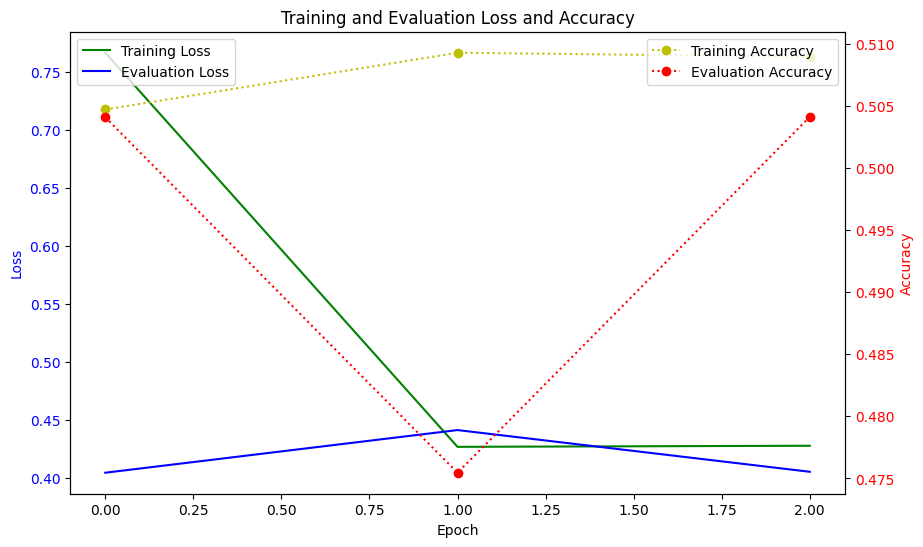

In [22]:
loss_n_accuracy_plt(train_losses,test_losses, train_accuracy_lst, test_accuracy_lst)

#### LSTM with Linear Output

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, feature_num, hidden_layer_size, pred_window):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=feature_num,
                            hidden_size=hidden_layer_size,
                            batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, pred_window)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Use only the last timestep's output
        return predictions

In [24]:
model = LSTMModel(feature_num = feature_num, hidden_layer_size = 64, pred_window = 4)
if torch.cuda.is_available():
    model = model.cuda()

In [25]:
train_losses, test_losses, train_cm_dicts, test_cm_dicts = train_model(model)
train_accuracy_lst = [x['accuracy'] for x in train_cm_dicts]
test_accuracy_lst = [x['accuracy'] for x in test_cm_dicts]

0
Training Confusion Matrix:
+-------------+-----------------+---------------------------------+-------------------+
| Actual\Pred |     Positive    |             Negative            |                   |
+-------------+-----------------+---------------------------------+-------------------+
|   Positive  |      502134     |              496238             |    Recall: 0.50   |
|   Negative  |      441345     |              465799             | Specificity: 0.51 |
|             | Precision: 0.53 | Negative predictive value: 0.48 |   Accuracy: 0.51  |
+-------------+-----------------+---------------------------------+-------------------+
Testing Confusion Matrix:
+-------------+-----------------+---------------------------------+-------------------+
| Actual\Pred |     Positive    |             Negative            |                   |
+-------------+-----------------+---------------------------------+-------------------+
|   Positive  |      149965     |              19284             

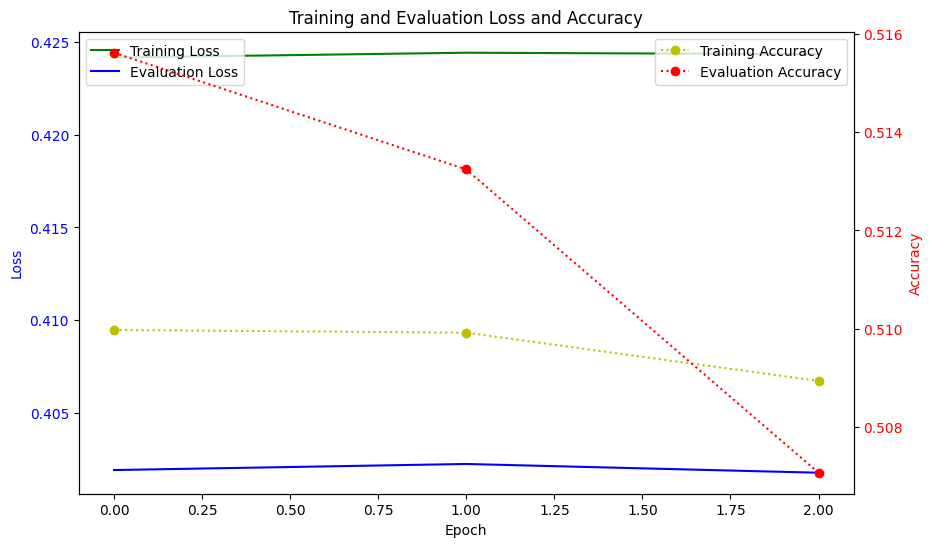

In [26]:
loss_n_accuracy_plt(train_losses,test_losses, train_accuracy_lst, test_accuracy_lst)